In [1]:
import numpy as np
import skimage.measure
import matplotlib.pyplot as plt
from skimage import io, color, img_as_ubyte, filters
from skimage.segmentation import active_contour

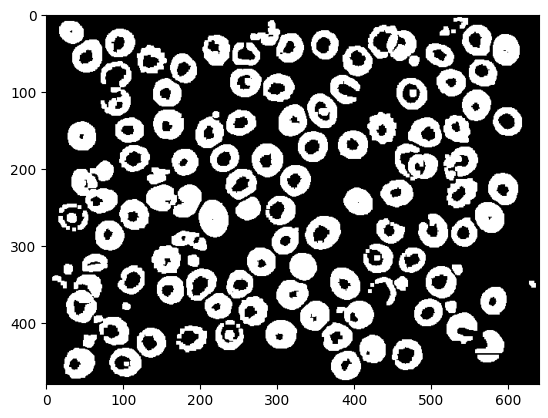

In [8]:
import cv2
import numpy as np
import skimage.measure
from skimage import filters
import matplotlib.pyplot as plt

def label_connected_components(binary_image, image):
    # Label connected components
    labeled_image = skimage.measure.label(binary_image, connectivity=1)
    
    # Extract properties of labeled regions
    regions = skimage.measure.regionprops(labeled_image)
    
    # Overlay component numbers on the original image
    count = 0
    cell_factors = {}
    for region in regions:
        centroid = region.centroid
        major_axis_length = region.major_axis_length
        minor_axis_length = region.minor_axis_length
        perimeter = region.perimeter
        area = region.area
        label = region.label
        
        # Calculate circularity factor
        form_factor = (4 * np.pi * area) / (perimeter ** 2)

        circularity = -1
        deviation = -1
        semilunnarity = -1
        if minor_axis_length != 0:
            circularity = (2*major_axis_length) / minor_axis_length
            semilunnarity = major_axis_length /( major_axis_length - minor_axis_length)

        if area != 0:
            deviation = circularity / area

        # Store factors for each cell
        cell_factors[label] = {
            'Centroid': centroid,
            'Circularity Factor': circularity,
            'Deviation Factor': deviation,
            'Form Factor': form_factor,
                'Semilunnarity': semilunnarity
            }

        count += 1
        cv2.putText(image, str(label), (int(centroid[1]), int(centroid[0])),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2, cv2.LINE_AA)
    
    return (image, cell_factors)

def process_image(image_path):
    # Read the image
    image = cv2.imread(image_path)

    # Convert to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Contrast adjustment (histogram equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_adjusted_image = clahe.apply(grayscale_image)

    ret, binary_image = cv2.threshold(contrast_adjusted_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    kernel = np.ones((5, 5), np.uint8)
    filled_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(filled_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = []
    min_area = 10  # Minimum area to keep (adjust based on image and objects)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > min_area:
            filtered_contours.append(cnt)


    mask = np.zeros(filled_image.shape, np.uint8)
    cv2.drawContours(mask, filtered_contours, -1, (255, 255, 255), -1)
    cleaned_image = cv2.bitwise_and(cv2.bitwise_not(filled_image), (mask))
    edges = filters.sobel(cleaned_image)

    labeled_image = skimage.measure.label(cleaned_image, connectivity=2)

# Convert the labeled image to a uint8 array
    labeled_image = labeled_image.astype(np.uint8)

# Find contours of each labeled region
    contours, _ = cv2.findContours(labeled_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw circles around each labeled region
    cv2.drawContours(image, contours, -1, (0, 255, 0), 2)
    for i ,contour in enumerate(contours):
        if(len(contour)>=5):

           

            ellipse=cv2.fitEllipse(contour)
             
            (x,y),(Ma,ma),angle=ellipse
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            
           # cv2.ellipse(image,ellipse,(0,255,0),2)
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
               
                cv2.putText(image, str(i+1), (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
   
       
    

# For better visualization, convert the labeled image to color
    # labeled_image = cv2.cvtColor(np.uint8(labeled_image * 255 / num_labels), cv2.COLOR_GRAY2BGR)


    # labeled_image, cell_factors = label_connected_components(filled_image, image)

    # # Print factors for each cell
    # for label, factors in cell_factors.items():
    #     print(f"Cell {label}:")
    #     print(f"Centroid: {factors['Centroid']}")
    #     print(f"Circularity Factor: {factors['Circularity Factor']}")
    #     print(f"Deviation Factor: {factors['Deviation Factor']}")
    #     print(f"Form Factor: {factors['Form Factor']}")
    #     print(f"Semilunnarity: {factors['Semilunnarity']}")
    #     print()
    
    plt.imshow(cleaned_image, cmap='gray')
    plt.show()

# Replace 'path/to/your/image.jpg' with your actual image path
process_image("151.jpg")


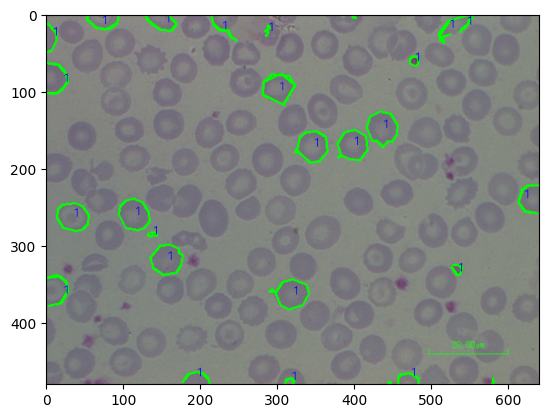

In [48]:
import cv2
import numpy as np
count=0
# Load the image
image = cv2.imread('151.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Perform edge detection using Canny
edges = cv2.Canny(blurred,10,50)
# Find contours in the edged image
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Loop over the contours
for contour in contours:
    # Approximate the contour
    epsilon = 0.01678 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    
    # If the contour has a certain number of vertices (indicating pointed edges)
    if len(approx) >= 10  and len(approx)<12:
        # Draw the contour on the original image
        cv2.drawContours(image, [approx], -1, (0, 255, 0), 2)
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.putText(image, str(count+1), (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

# Display the result
plt.imshow(image, cmap='gray')
plt.show()



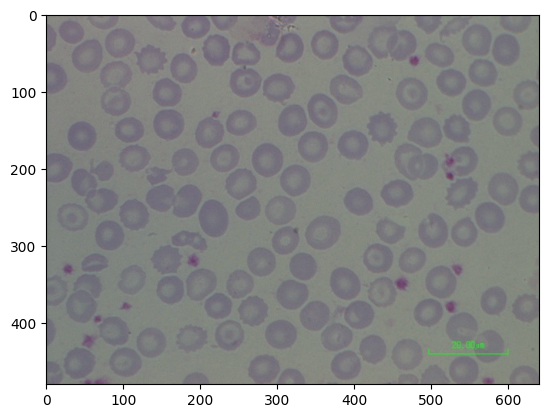

In [3]:
import cv2
import numpy as np
import skimage.measure
from skimage import filters
import matplotlib.pyplot as plt

image = cv2.imread("151.jpg")



plt.imshow(image, cmap='gray')
plt.show()